# COVID-19 Cases vs. Tweets

The goal is to analyse how the number of Tweets regarding COVID-19 correlates with the case numbers in Germany. Due to the restrictions of the Twitter API, prominent Twitter accounts of German Politicians will be used instead of statistics of the general population.

This analysis could easily be expanded for other countries and their politicians, or a more general population using the geolocation of tweets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For COVID data
import pandas as pd

# For Twitter Data
import json
import tweepy
from pymongo import MongoClient

## COVID-19 Data

The data was downloaded from Our World in Data on December 31st, 2020 and is updated daily. The data was saved in a csv file. Alternatively, they provide code in a github to automatically pull the newest data.

source: https://ourworldindata.org/coronavirus/country/germany?country=~DEU, https://github.com/owid/covid-19-data

In [2]:
data = pd.read_csv('data/owid-covid-data.csv', header=0)

In [3]:
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [4]:
# Check whether data format should be converted
# data.dtypes
# data.memory_usage(index=False)
# data.astype('category').memory_usage(index=False)

In [5]:
# Filter data for Germany
data_ger = data.loc[data['location'] == 'Germany']

In [6]:
data_ger.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
19415,DEU,Europe,Germany,2020-01-27,1.0,1.0,NaN,NaN,NaN,NaN,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
19416,DEU,Europe,Germany,2020-01-28,4.0,3.0,NaN,NaN,NaN,NaN,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
19417,DEU,Europe,Germany,2020-01-29,4.0,0.0,NaN,NaN,NaN,NaN,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
19418,DEU,Europe,Germany,2020-01-30,4.0,0.0,NaN,NaN,NaN,NaN,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
19419,DEU,Europe,Germany,2020-01-31,5.0,1.0,NaN,NaN,NaN,NaN,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936


In [7]:
def makePlot(data, title, xlabel, ylabel):
    """Function to create plots for the COVID-19 data

    Parameters
    ----------
    data : array, first column contains the dates, second column contains the data
    title : str
    xlabel : str
    ylabel : str
    """
    
    fig, ax = plt.subplots()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)

    # Convert dates
    date = [int(d[5:7]) - 1 + int(d[-2:])/32 for d in data[:,0]]
    ax.set_xlim(1, 12)

    # Plot
    ax.plot(date, data[:,1])

    plt.show()

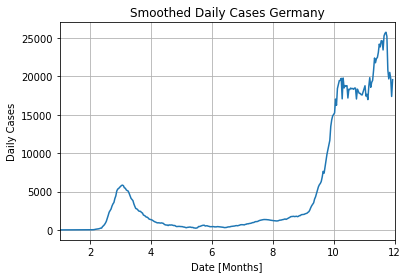

In [8]:
new_cases_smoothed = data_ger[['date','new_cases_smoothed']].values
makePlot(new_cases_smoothed, 'Smoothed Daily Cases Germany', 'Date [Months]', 'Daily Cases')

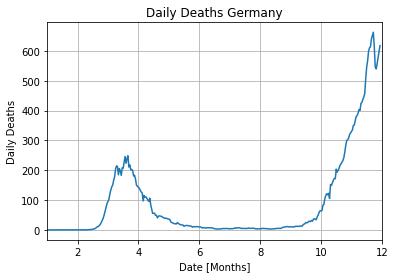

In [9]:
new_deaths_smoothed = data_ger[['date','new_deaths_smoothed']].values
makePlot(new_deaths_smoothed, 'Daily Deaths Germany', 'Date [Months]', 'Daily Deaths')

In [10]:
cases_stats = data_ger['new_deaths_smoothed'].describe()
print(cases_stats)

count    334.000000
mean      92.298982
std      150.679719
min        0.000000
25%        4.606750
50%       14.357000
75%      122.357000
max      662.286000
Name: new_deaths_smoothed, dtype: float64


In [11]:
deaths_stats = data_ger['new_deaths_smoothed'].describe()
print(deaths_stats)

count    334.000000
mean      92.298982
std      150.679719
min        0.000000
25%        4.606750
50%       14.357000
75%      122.357000
max      662.286000
Name: new_deaths_smoothed, dtype: float64


## Twitter Data

First, we must select the most popluar politicians in Germany.

### Ranking of the ten most popular German politicians on social networks in July 2020

<img src="images/german_politicians_statista.PNG" alt="Graph" style="width: 500px;"/>

source: https://www.statista.com/statistics/446360/social-media-ranking-of-the-most-popular-politicians-germany/


### Twitter Handles:
N/A <br>
@sebastiankurz <br>
@martinschulz <br>
@SWagenknecht <br>
N/A <br>
@GregorGysi <br>
@JunckerEU <br>
@MartinSonneborn <br>
@c_lindner <br>
@nicosemsrott


The trouble is that the most popular figure, Bundeskanzlerin Merkel, does not have a twitter account. Furthermore, the second on the list is Sebastian Kurz, an Austrian politician. Regardslessly, the tweets will be collected and analyzed. If necessary, the list can be expanded or adapted.

In [ ]:
# Users
USERS = ['sebastiankurz','martinschulz','SWagenknecht','GregorGysi',
    'JunckerEU','MartinSonneborn','c_lindner','nicosemsrott']

# Hashtags
WORDS = ['#covid','#coronavirus','#covid19','#corona']

In [ ]:
# Twitter Access
CONSUMER_KEY = None
CONSUMER_SECRET = None
ACCESS_TOKEN = None
ACCESS_TOKEN_SECRET = None

with open('keys.txt') as keys:
    CONSUMER_KEY = keys.readline().replace('\n', '')
    CONSUMER_SECRET = keys.readline().replace('\n', '')
    ACCESS_TOKEN = keys.readline().replace('\n', '')
    ACCESS_TOKEN_SECRET = keys.readline().replace('\n', '')

In [ ]:
# MongoDB Access
MONGO_DB_NAME = None
MONGO_PASSWORD = None

with open('mongodb.txt') as keys:
    MONGO_DB_NAME = keys.readline().replace('\n', '')
    MONGO_PASSWORD = keys.readline().replace('\n', '')

In [ ]:
# Login
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
class SearchTwitter():
    """Search for Tweets using the api"""

    def __init__(self, api):
        self.api = api
        self.START_DATE = 2020

        # Connect to mongoDB and stores the tweet
        try:
            self.client = MongoClient('mongodb+srv://kevinhuestis:' + 
                str(MONGO_PASSWORD) + '@cluster0.ahwbn.mongodb.net/' + 
                str(MONGO_DB_NAME) + '?retryWrites=true&w=majority')

            # Use test database
            self.db = self.client.test

        except Exception as e:
            print(e)

    def search_by_hashtag(self, words):
        """Search by Hashtag"""
        for data in api.search(q=words):
            try:      
                # Decode the Tweet
                datajson = json.loads(data)
                
                # Insert the data into the mongoDB
                self.db.userTweets.insert_one(datajson)

            except Exception as e:
                print(e)  

    
    def search_by_user(self, user):
        """ Search by User"""
        for status in self.limit_handled(tweepy.Cursor(api.user_timeline, id=user).items()):

            # Only search for tweets in 2020
            if status.created_at.year < self.START_DATE:
                break

            try:      
                # Decode the Tweet
                datadump = json.dumps(status._json)
                datajson = json.loads(datadump)
                
                # Insert the data into the mongoDB
                self.db.userTweets.insert_one(datajson)

            except Exception as e:
                print(e)     


    @classmethod
    def limit_handled(self, cursor):
        """Handles Twitter limit"""
        while True:
            try:
                yield cursor.next()
            except tweepy.RateLimitError:
                time.sleep(15 * 60)
            except Exception as e:
                print(e)

In [ ]:
searcher = SearchTwitter(api)

for user in USERS:
    searcher.search_by_user(user)
    print("Finished collecting Tweets from user " + user)

In [ ]:
for status in tweepy.Cursor(api.user_timeline, id=USERS[0]).items():
    tweet = status.text
    hashtags = status.entities['hashtags']
    tweet_date = status.created_at




### Twitter Hashtags:

## Alternative accounts:

@BMG_Bund